In [1]:
### SIMULATED_BNS_POPULATION.IPYNB -- model an astrophysically plausible merging BNS population, and sample masses, spins and tidal deformabilities from it

In [2]:
# load packages

import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# import sodapop

! python3 -m pip install bilby # only need to run this once
! python3 -m pip install lalsuite # only need to run this once

import bilby
import lal
import lalsimulation as lalsim

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
# user input

NUM_SAMPLES = 400 # number of samples to draw; this should be much larger than 10, 40 and 300000, which are reasonable yearly detection rates for O4, O5 and 3G, since it also includes undetected events
# see https://arxiv.org/abs/2204.07592, https://arxiv.org/abs/2204.12504, https://arxiv.org/abs/2003.04880, https://arxiv.org/abs/2111.03634, https://arxiv.org/abs/1304.0670, https://arxiv.org/abs/2109.09882

OUTPUT_PATH = './dat/O5_unif_BNS_DBHF2010/BNS_MassesSpinsLambdas.csv'

EOS_PATH = './etc/macro-DBHF_2010.csv' # EOS M-Lambda table

MMIN = 1.0 # minimum NS mass on grid
MMAX = 2.3 # maximum NS mass on grid

def NS_MASS_PDF(m,params): # NS mass distribution probability density function

  mmin, mmax = params
	
  if np.isscalar(m): m = np.array([m])
  else: m = np.array(m)
  z = np.zeros(len(m))
	
  p = np.full(len(m),1./(mmax-mmin)) # uniform mass distribution
	# FIXME: below is a hack to exclude unstable mass range, in general want to look at dM/drhoc
  return np.where((m > mmax) | (m < mmin) | ((m < 1.07345873119951) & (m > 1.06803390206334)), z, p) # this enforces the mmin and mmax cutoffs

def BNS_MASS_PDF(m1,m2,params): # BNS mass distribution probability density function

  if np.isscalar(m1): m1 = np.array([m1])
  else: m1 = np.array(m1)
  if np.isscalar(m2): m2 = np.array([m2])
  else: m2 = np.array(m2)
  z = np.zeros(len(m1))

  p = NS_MASS_PDF(m1,params)*NS_MASS_PDF(m2,params) # random pairing of m1, m2 drawn from same underlying NS mass distribution
	
  return np.where(m1 < m2, z, p) # this enforces m2 < m1

CHI1MAX = 0.05
CHI2MAX = 0.01

def SPIN_PDF(chi,params): # spin distribution probability density function

  chimin, chimax = params
	
  if np.isscalar(chi): chi = np.array([chi])
  else: chi = np.array(chi)
  z = np.zeros(len(chi))
	
  p = np.full(len(chi),1./(chimax-chimin)) # uniform spin distribution
	
  return np.where((chi > chimax) | (chi < chimin), z, p) # this enforces the chimin and chimax cutoffs

DLMAX = 350. # Mpc; 200, 350, 100000 are reasonable range estimates for O4, O5, 3G; see https://arxiv.org/abs/1304.0670, https://arxiv.org/abs/2109.09882

def DL_PDF(dl,params): # luminosity distance distribution probability density function

  dlmin, dlmax = params
	
  if np.isscalar(dl): dl = np.array([dl])
  else: dl = np.array(dl)
  z = np.zeros(len(dl))
	
  p = dl**2 # uniform in comoving volume distribution # FIXME: need to switch to cosmological distribution for 3G
	
  return np.where((dl > dlmax) | (dl < dlmin), z, p) # this enforces the dlmin and dlmax cutoffs

In [5]:
# get M-Lambda relation

eos_dat = np.genfromtxt(EOS_PATH,names=True,delimiter=',',dtype=None,encoding=None) # load EOS table
Ms = eos_dat['M']
Lambdas = eos_dat['Lambda']

Mmax_pos = np.argmax(Ms) # truncate table at maximum NS mass
Ms = Ms[:Mmax_pos+1]
Mmax = Ms[-1]
Lambdas = Lambdas[:Mmax_pos+1]

Lambda_of_M = interp1d(Ms,Lambdas,kind='linear',bounds_error=True) # interpolate Lambda(M) function

In [6]:
# get mass samples

m_grid = np.arange(max(MMIN,min(Ms)),min(MMAX,max(Ms)),0.001) # regular grid in NS masses

m1m2_grid = []
for m1 in m_grid:
    for m2 in m_grid:
        m1m2_grid += [(m1,m2)] # regular 2D grid in BNS masses

m1s_grid = np.array([m1 for m1,m2 in m1m2_grid]) # m1 points from the 2D grid
m2s_grid = np.array([m2 for m1,m2 in m1m2_grid]) # m2 points from the 2D grid
grid_pts = range(len(m1m2_grid)) # label each point in 2D grid

m1m2_wts = BNS_MASS_PDF(m1s_grid,m2s_grid,(MMIN,Mmax)) # weight each binary mass grid point by its probability according to the chosen BNS mass distribution, and truncate at the EOS's Mmax

sample_pts = np.random.choice(grid_pts,NUM_SAMPLES,replace=True,p=m1m2_wts/np.sum(m1m2_wts)) # draw samples from BNS mass distribution
m1s = m1s_grid[sample_pts]
m2s = m2s_grid[sample_pts]

In [7]:
# get corresponding Lambda samples

Lambda1s = Lambda_of_M(m1s) # use interpolated M-Lambda relation
Lambda2s = Lambda_of_M(m2s)

In [8]:
# get spin samples

chi_grid = np.arange(0.,1.,0.001) # regular grid in NS spins

chi1_wts = SPIN_PDF(chi_grid,(0.,CHI1MAX))
chi2_wts = SPIN_PDF(chi_grid,(0.,CHI2MAX))

chi1s = np.random.choice(chi_grid,NUM_SAMPLES,replace=True,p=chi1_wts/np.sum(chi1_wts)) # draw samples from spin distributions
chi2s = np.random.choice(chi_grid,NUM_SAMPLES,replace=True,p=chi2_wts/np.sum(chi2_wts))

In [9]:
# get luminosity distance samples

dl_grid = np.arange(0.,DLMAX,0.1) # regular grid in luminosity distance

dl_wts = DL_PDF(dl_grid,(0.,DLMAX))

dls = np.random.choice(dl_grid,NUM_SAMPLES,replace=True,p=dl_wts/np.sum(dl_wts))

In [10]:
# sample in sky location parameters

dec_grid = np.arange(0.,2.*np.pi,0.01)
dec_wts = [np.abs(np.cos(dec)) for dec in dec_grid]
decs = np.random.choice(dec_grid,NUM_SAMPLES,replace=True,p=dec_wts/np.sum(dec_wts))

thetajn_grid = np.arange(0.,2.*np.pi,0.01)
thetajn_wts = [np.abs(np.sin(thetajn)) for thetajn in thetajn_grid]
thetajns = np.random.choice(thetajn_grid,NUM_SAMPLES,replace=True,p=thetajn_wts/np.sum(thetajn_wts))

ras = np.random.uniform(0.,2.*np.pi,NUM_SAMPLES)
psis = np.random.uniform(0.,np.pi,NUM_SAMPLES)
phases = np.random.uniform(0.,2.*np.pi,NUM_SAMPLES)

In [11]:
# calculate event signal to noise ratios (SNRs) based on its source parameters

snrs = []

for m1,m2,chi1,chi2,Lambda1,Lambda2,dl,dec,thetajn,ra,psi,phase in zip(m1s,m2s,chi1s,chi2s,Lambda1s,Lambda2s,dls,decs,thetajns,ras,psis,phases):

  injection_parameters = dict(
    mass_1=m1, mass_2=m2, chi_1=chi1, chi_2=chi2, luminosity_distance=dl,
    theta_jn=thetajn, psi=psi, phase=phase, geocent_time=1126259642.413,
    ra=ra, dec=dec, lambda_1=Lambda1, lambda_2=Lambda2)

  duration = 32
  sampling_frequency = 2 * 1024
  start_time = injection_parameters['geocent_time'] + 2 - duration

  waveform_arguments = dict(waveform_approximant='IMRPhenomPv2_NRTidal', # note: this waveform assumes aligned spins
                          reference_frequency=50., minimum_frequency=40.0)
  waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments)

  interferometers = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])
  for interferometer in interferometers:
    interferometer.minimum_frequency = 40
  interferometers.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration, start_time=start_time)

  injection_polarizations = waveform_generator.frequency_domain_strain(injection_parameters)
  signal_ifos = [interferometer.get_detector_response(injection_polarizations, injection_parameters) for interferometer in interferometers]

  network_snr = np.sqrt(np.sum([interferometer.optimal_snr_squared(signal=signal_ifo) for interferometer,signal_ifo in zip(interferometers,signal_ifos)])).real

  snrs += [network_snr]

13:11 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters
13:11 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters
13:11 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters
13:11 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_par

In [12]:
# extract loudest events

NUM_LOUD_EVENTS = 400 # for typical application, retain all the events and cut by snr 12 detection threshold and mass bin later
loud_idxs = np.argpartition(snrs, -NUM_LOUD_EVENTS)[-NUM_LOUD_EVENTS:]

loud_m1s = m1s[loud_idxs]
loud_m2s = m2s[loud_idxs]
loud_chi1s = chi1s[loud_idxs]
loud_chi2s = chi2s[loud_idxs]
loud_Lambda1s = Lambda1s[loud_idxs]
loud_Lambda2s = Lambda2s[loud_idxs]
loud_snrs = np.array(snrs)[loud_idxs]
loud_dls = dls[loud_idxs]
loud_decs = decs[loud_idxs]
loud_ras = ras[loud_idxs]
loud_psis = psis[loud_idxs]
loud_phases = phases[loud_idxs]
loud_thetajns = thetajns[loud_idxs]

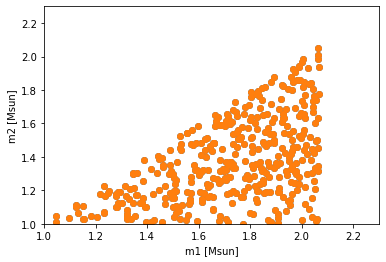

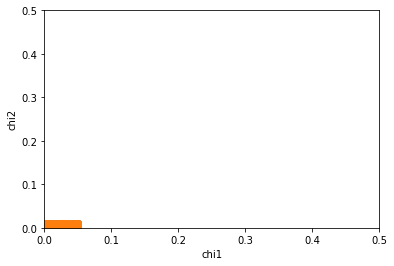

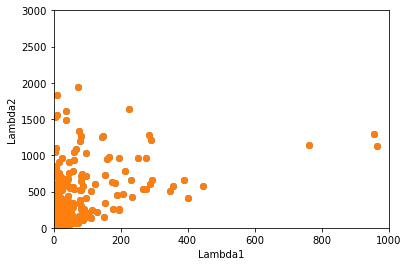

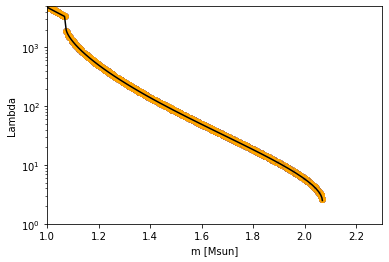

In [13]:
# plot the mass, spin and Lambda samples

plt.scatter(m1s,m2s) # scatter plot of BNS masses
plt.scatter(loud_m1s,loud_m2s) # highlight loudest events

plt.xlabel('m1 [Msun]')
plt.ylabel('m2 [Msun]')
plt.xlim(MMIN,MMAX)
plt.ylim(MMIN,MMAX)
plt.show()

###

plt.scatter(chi1s,chi2s) # scatter plot of BNS spins
plt.scatter(loud_chi1s,loud_chi2s) # highlight loudest events

plt.xlabel('chi1')
plt.ylabel('chi2')
plt.xlim(0.,0.5)
plt.ylim(0.,0.5)
plt.show()

###

plt.scatter(Lambda1s,Lambda2s) # scatter plot of BNS Lambdas
plt.scatter(loud_Lambda1s,loud_Lambda2s) # highlight loudest events

plt.xlabel('Lambda1')
plt.ylabel('Lambda2')
plt.xlim(0.,1000.)
plt.ylim(0.,3000.)
plt.show()

###

plt.plot(Ms,Lambdas,c='k') # m1-Lambda1 and m2-Lambda2 samples overlaid on EOS's M-Lambda relation
plt.scatter(m1s,Lambda1s,c='b')
plt.scatter(loud_m1s,loud_Lambda1s,c='orange') # highlight loudest events
plt.scatter(m2s,Lambda2s,c='b')
plt.scatter(loud_m2s,loud_Lambda2s,c='orange') # highlight loudest events

plt.yscale('log')
plt.xlabel('m [Msun]')
plt.ylabel('Lambda')
plt.xlim(MMIN,MMAX)
plt.ylim(1.,5000.)
plt.show()

In [14]:
# save samples to a csv file

output_dat = np.column_stack((loud_m1s,loud_m2s,loud_chi1s,loud_chi2s,loud_Lambda1s,loud_Lambda2s,loud_dls,loud_snrs,loud_decs,loud_ras,loud_thetajns,loud_psis,loud_phases)) # collect data columns into an array
cols = 'm1,m2,chi1,chi2,Lambda1,Lambda2,dl,snr,dec,ra,theta_jn,psi,phase'
np.savetxt(OUTPUT_PATH,output_dat,delimiter=',',comments='',header=cols)